# Economic Growth

# 8.4.1 モデルについて

あるcomposite goodを生産し、消費する経済を考える.

・毎年、財は数量$s$で始まり、うち$x$が投資に、残り$(s-x)$が消費に充てられる.

・また、social benefitとして$u(s-x)$が生じる.

・毎年はじめに利用できる財の量はcontinuous-valued Markov processによって以下のようにコントロールされる

$$s_{t+1} = \gamma x_t + \epsilon_{t+1}h(x_t)$$

・$\gamma$はcapital survival rate(1-減価償却率)、$h$は総生産関数、$\epsilon$は正の生産ショック(平均が1)を表す.

ここでは、現在、そして将来にわたるsocial benefitの総和を最大化するような消費と投資のpolicyについて考える.

・このモデルはinfinite horizonである.$ｘ$は投資量を決定するアクションである.

$$s\in[0,\infty), x\in[0,s]$$

・状態遷移関数(state transition function)は次のように表される.

$$g(s,x,\epsilon)=\gamma x + \epsilon h(x)$$

・reward functionは次のように表される.

$$f(s,x)=u(s-x)$$

ストック$s$が与えられたとき、現在と将来のsocial benefitの和はBellman equationを満たす.

$$V(s)=\max_{0\leq x \leq s}\{u(s-x) + \delta E_\epsilon V(\gamma x +\epsilon h(x))\}$$

$u'(0)=\infty$と$h(0)=0$を仮定すると、最適条件ではconstraintsは拘束力を持たない

In [1]:
using QuantEcon
using BasisMatrices
using Optim

In [2]:
using Interpolations

In [3]:
using Plots

In [4]:
struct GrowthModel
    alpha::Float64
    beta::Float64
    gamma::Float64
    sigma::Float64
    delta::Float64 #discount factor
    s_vec::Vector{Float64}
end

In [5]:
n = 500 #ここを大きくするとdpsimulのspathが7.5に近づく
smin = 0
smax = 10
fspace = Basis(ChebParams(n, smin, smax))

snodes = nodes(fspace);

In [6]:
GM = GrowthModel(0.2, 0.5, 0.9,0.1,0.9, snodes[1])

GrowthModel(0.2, 0.5, 0.9, 0.1, 0.9, [2.4674e-5, 0.000222064, 0.000616838, 0.00120898, 0.00199846, 0.00298526, 0.00416933, 0.00555063, 0.00712909, 0.00890467  …  9.9911, 9.99287, 9.99445, 9.99583, 9.99701, 9.998, 9.99879, 9.99938, 9.99978, 9.99998])

In [7]:
function update_bellman!(GM::GrowthModel,V::Vector)
    a,b,g,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta
    V_func = LinInterp(GM.s_vec, V)
    V_new = similar(V)
    x_opt = similar(V)
    
    nshocks = 3
    e,w = qnwlogn(nshocks,-(sigma^2)/2,sigma^2)
    
    for (s_idx,s) in enumerate(GM.s_vec)
        objective(x) = -(((s - x)^(1 - a)/(1 - a)) + d * dot(V_func.(g*x + e*(x^b)), w))
        opt = optimize(objective, 1e-10, s)
        V_new[s_idx] = - opt.minimum
        x_opt[s_idx] = opt.minimizer
    end
    return V_new,x_opt
end

update_bellman! (generic function with 1 method)

In [8]:
V = Vector{Float64}(length(GM.s_vec))
for i in 1:length(GM.s_vec)
V[i] = 5
end

In [9]:
n = 500
V_computed = similar(V)
x_opt = similar(V)
resid1 = Vector{Float64}(n)

for i in 1:n
    V_func =  LinInterp(snodes[1], V)
    V_computed, x_opt = update_bellman!(GM,V)
    for j in 1:length(V_computed)
        resid1[j] =  V_computed[j] - V[j]
    end
    copy!(V, V_computed)
end


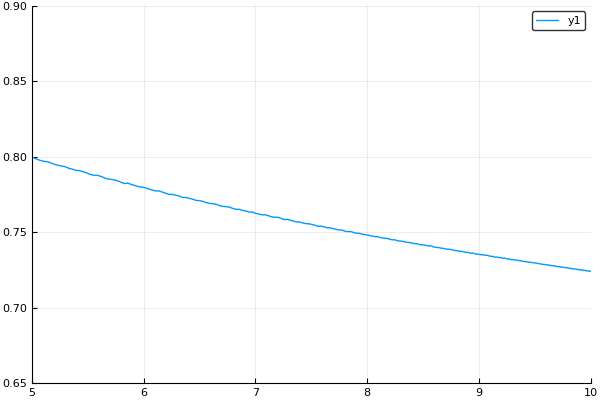

In [10]:
x_per = similar(V)
for i in 1:length(x_per)
    x_per[i] = x_opt[i] / GM.s_vec[i]
end

plot(GM.s_vec, x_per,xlim=(5,10),ylim=(0.65,0.9))


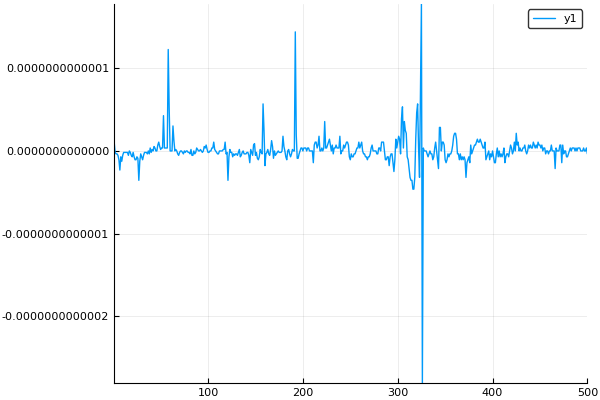

In [11]:
plot(resid1)

LQapprox部分の実装

方法１

In [155]:
GM::GrowthModel
a,b,gamma,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta

estar = 1 #教科書訂正
xstar = ((1 - d*gamma)/(d*b))^(1/(b - 1))
sstar = gamma*xstar + xstar^b
cstar = sstar - xstar

gx = gamma+b*((xstar)^(b-1))
f = (cstar^(-a))/(1-a)
fs = cstar^(-a)
fss = -a*(cstar^(-a-1))

A = [0 gamma*xstar+(xstar^b)-sstar;
     0                 1]
B = [gx;
     0]
C = zeros(2,1)

R = [-1/2*fss -1/2*fs;
     -1/2*fs  -f]
Q = -1/2*fss
N = [1/2*fss 1/2*fs]

lq = LQ(Q,R,A,B,C,N; bet=d)

P, F, d =  stationary_values(lq)

([0.0 -2.84217e-14; 0.0 -51.2464], [-1.0 9.0374], 0.0)

方法２:transition functionをreward functionに入れ込む

In [17]:
GM::GrowthModel
a,b,gamma,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta

estar = 1 #教科書訂正
xstar = ((1 - d*gamma)/(d*b))^(1/(b - 1))
sstar = gamma*xstar + xstar^b
cstar = sstar - xstar

m1 = gamma*sstar + sstar^b -xstar
m2 = gamma+b*(sstar)^(b-1)

u = (m1^(1-a))/(1-a)
us = (m1^(-a))*m2
ux = -(m1^(-a))
uss = m1^(-a)*(b-1)*sstar^(b-2) + m2^2*(-a)*m1^(-a-1)
uxx = -a*(m1^(-a-1))
usx = a*(m1^(-a-1))*m2

A = zeros(2,2)
B = [1;
     0]
C = zeros(2,1)

R = [-1/2*uss -1/2*us;
     -1/2*us -u]
Q = -1/2*uxx

N = [-1/2*usx -1/2*ux]

lq = LQ(Q,R,A,B,C,N; bet=d)

P, F, d =  stationary_values(lq)

([0.0209329 -0.200212; -0.200212 -7.38542], [-0.560922 9.80736], 0.0)

In [45]:
s0 = [5.0;1.0]
s_path,x_path = compute_sequence(lq,s0)

([5.0 -7.00275 … -1.72873e-24 -9.69682e-25; 1.0 0.0 … 0.0 0.0], [-7.00275 -3.928 … -1.72873e-24 -9.69682e-25], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [46]:
s_path

2×101 Array{Float64,2}:
 5.0  -7.00275  -3.928  -2.2033  -1.23588  …  -1.72873e-24  -9.69682e-25
 1.0   0.0       0.0     0.0      0.0          0.0           0.0        

In [47]:
-x_path

1×100 Array{Float64,2}:
 7.00275  3.928  2.2033  1.23588  0.693233  …  1.72873e-24  9.69682e-25

In [50]:
slq = reshape(x_path,100,1);


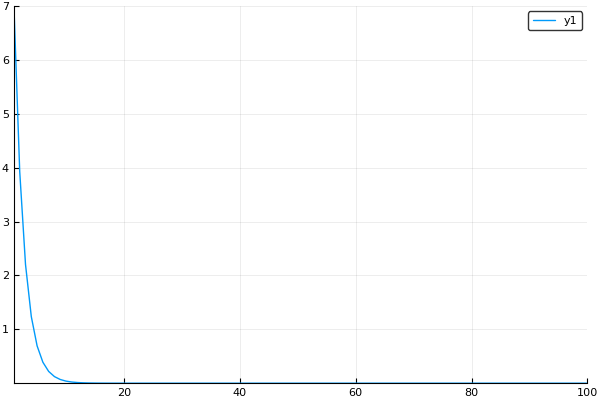

In [49]:
plot(-slq)

dpsimulの実装

In [16]:
function GM_dpsimul(GM::GrowthModel,sinit,nyrs,sres,xres)
    a,b,g,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta

    nrep = length(sinit) #npath
    nshocks = 3
    e,w = qnwlogn(nshocks,-(sigma^2)/2,sigma^2)
    ssim = zeros(nrep,nyrs+1)
    xsim = zeros(nrep,nyrs+1)
    
    rv = DiscreteRV(w)
    trans(x) = (g*x) + e[rand(rv)]*x^b #state transition function
        
    for t in 1:nyrs+1
        li = LinInterp(sres, xres)
        xx = Vector{Float64}(length(sinit))
        for i in 1:length(sinit)
            xx[i]=li(sinit[i])
        end
        ssim[:,t] = sinit
        xsim[:,t]= xx
        for i in 1:length(sinit) -1
            sinit[i+1] = trans(xx[i])
        end
    end
        
    return ssim,xsim
end

GM_dpsimul (generic function with 1 method)

In [17]:
nshocks = 3
    e,w = qnwlogn(nshocks,-(sigma^2)/2,sigma^2)
d = DiscreteRV(w);

e[rand(d, 5)]

5-element Array{Float64,1}:
 0.995012
 0.995012
 1.18318 
 0.995012
 0.995012

In [18]:
nyrs = 20
npath = 2000
sinit = 5*ones(npath,1) 

spath,xpath = GM_dpsimul(GM,sinit,nyrs,snodes[1],x_opt);

In [19]:
spath_x = vec(mean(spath,1))

21-element Array{Float64,1}:
 5.0    
 5.60674
 6.08086
 6.43267
 6.70124
 6.90166
 7.04129
 7.12591
 7.21394
 7.27053
 7.30821
 7.33375
 7.34927
 7.36368
 7.36579
 7.3715 
 7.38197
 7.39427
 7.40622
 7.40542
 7.40585


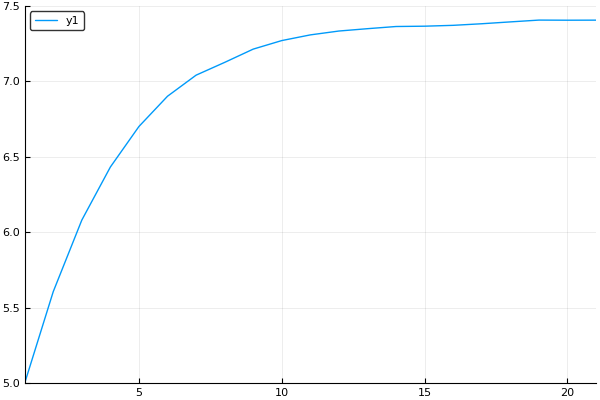

In [20]:
plot(spath_x,ylim=(5.0,7.5))

dpststの実装

In [38]:
function dpstst(GM::GrowthModel,nsmooth,nnodes,scoord,x)
    a,b,g,sigma,d = GM.alpha, GM.beta, GM.gamma, GM.sigma, GM.delta
    smin = scoord[1]
    smax = scoord[end]
    swid = (smax - smin)/nnodes
    smid = linspace(smin+swid/2,smax-swid/2,nnodes) 
    nshocks = 3
    e,w = qnwlogn(nshocks,-(sigma^2)/2,sigma^2)
    
    m = length(w)
    ss = gridmake(smid)
    xx = similar(ss)
    q = ones(length(ss))
    li = LinInterp(scoord,x)
    for t in 1:nsmooth
        for k in 1:length(ss)
            xx[k] = li(ss[k])
        end
        ss,xx,ee = gridmake([ss,xx],e)
        for r in 1:length(ss)
            ss[r] = g*xx[r] + xx[r]^b
        end
        for l in 1:length(ss)
            q[l] = q[l]*w' #?
        end
    end
    nobs = m^nsmooth
    ss = reshape(ss,nnodes,nobs)
    q = reshape(q,nnodes,nobs)
        
    p = zeros(nnodes,nnodes)
    for j in 1:nobs
        i = ceil((ss[:,j]-smin)/swid)
        i = min(max(i,1),nnodes)
        ind = (1:nnodes)'+(i-1)*nnodes
        p[ind] = p[ind] + q[i,j]
    end
    mc = MarkovChain(p)
    p = stationary_distributions(mc)
    
    return smid,p,xx
end

dpstst (generic function with 1 method)

In [39]:
h = 5
nbins = 80
ss,pi,xx = dpstst(GM,h,nbins,GM.s_vec,x_opt)

LoadError: [91mMethodError: Cannot `convert` an object of type RowVector{Float64,Array{Float64,1}} to an object of type Float64
This may have arisen from a call to the constructor Float64(...),
since type constructors fall back to convert methods.[39m